<a href="https://colab.research.google.com/github/pias97/Fake-News-Detection-on-Bangla-Dataset/blob/main/ML_Project_v2(Deafult_Stopwords).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bangla Fonts & Libraries

In [ ]:
pip install bnlp_toolkit

In [ ]:
import re
from bnlp.corpus import stopwords, punctuations 

In [ ]:
!wget https://www.omicronlab.com/download/fonts/kalpurush.ttf

In [ ]:
!wget https://www.omicronlab.com/download/fonts/Siyamrupali.ttf

#Importing Libraries

In [ ]:
#Libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import itertools

  
#Feature extraction and splitting
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


#Model
from sklearn import naive_bayes
from sklearn.svm import SVC

#Evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score


**Confusion Matrix Library**

In [ ]:
def plot_confusion_matrix(cm, classes, extention,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title +" "+ extention)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Dataset Loading

In [ ]:
data = pd.read_excel("/content/FinalData1.xlsx")
data.head(10)

,Title,Statement,Category,Source,Date,Class
0,"এক দিনে করোনায় মৃত্যু ১৫ জনের, নতুন শনাক্ত ২৬৬",\n\nদেশে করোনাভাইরাসে আক্রান্ত হয়ে গত ২৪ ঘণ্টা...,বাংলাদেশ সংবাদ,https://www.prothomalo.com/bangladesh/article/...,"\n১৭ এপ্রিল ২০২০, ১৪:৪১\n\n\t\t\t\t\t\t\tআপডেট...",Real
1,কোভিড-১৯-এর কাছে মানবজাতি হেরে গেল কেন?,\n\nদ্বিতীয় বিশ্বযুদ্ধের পর থেকে বিশ্বের প্রভু...,অন্য আলো সংবাদ,https://www.prothomalo.com/bangladesh/article/...,"\n১৭ এপ্রিল ২০২০, ১৪:৩৯\n\n\t\t\t\t\t\t\tআপডেট...",Real
2,সত্যিকারের ম্যাজিক!,"\n\nবাড়ির পাশেই ভিক্টোরিয়া পার্ক, বিকেল হলেই স...",অন্য আলো সংবাদ,https://www.prothomalo.com/bangladesh/article/...,"\n১৭ এপ্রিল ২০২০, ১৪:৩৭\n\n\t\t\t\t\t\t\tআপডেট...",Real
3,এই সঙ্গনিরোধকালে,\n\nবাইরে বেরোচ্ছি না বেশ কিছুদিন ধরে। বলা ভাল...,অন্য আলো সংবাদ,https://www.prothomalo.com/bangladesh/article/...,"\n১৭ এপ্রিল ২০২০, ১৪:৩০\n\n\t\t\t\t\t\t\tআপডেট...",Real
4,কী করছেন ঘরবন্দী লেখকেরা,\n\nসবার মতো লেখকেরাও এখন ঘরবন্দী। লেখকদের এই ...,অন্য আলো সংবাদ,https://www.prothomalo.com/bangladesh/article/...,"\n১৭ এপ্রিল ২০২০, ১৪:২৩\n\n\t\t\t\t\t\t\tআপডেট...",Real
5,স্বাস্থ্যব্যবস্থা নতুন করে সাজানোর বিকল্প নেই,\n\nদুনিয়া কাঁপানো গত ১০০ দিনে সারা বিশ্বের জন...,মতামত সংবাদ,https://www.prothomalo.com/bangladesh/article/...,"\n১৭ এপ্রিল ২০২০, ১৪:১১\n\n\t\t\t\t\t\t\tআপডেট...",Real
6,করোনায় পরিবারকে সবচেয়ে বড় ‘উপহারটি’ দিন,\n\nকরোনাভাইরাস সংক্রমণে বিশ্ব স্থবির হয়ে পড়ায়...,খেলা সংবাদ,https://www.prothomalo.com/bangladesh/article/...,"\n১৭ এপ্রিল ২০২০, ১৪:৪৫\n\n\t\t\t\t\t\t\tআপডেট...",Real
7,তরুণদের জন্য ‘অ্যাক্ট কোভিড-১৯’ অনলাইন হ্যাকাথন,\n\nকোভিড-১৯ পরিস্থিতি মোকাবিলায় সরকারের তথ্য ...,বিজ্ঞান ও প্রযুক্তি সংবাদ,https://www.prothomalo.com/bangladesh/article/...,"\n১৭ এপ্রিল ২০২০, ১৩:৫৫\n\n\t\t\t\t\t\t\tআপডেট...",Real
8,বিশেষ চাহিদাসম্পন্ন সন্তান ও অভিভাবকদের ভোগান্...,"\n\nকরোনাভাইরাসের বিস্তারের এই সময়ে অটিস্টিক, ...",বাংলাদেশ সংবাদ,https://www.prothomalo.com/bangladesh/article/...,"\n১৭ এপ্রিল ২০২০, ১৩:৪৩\n\n\t\t\t\t\t\t\tআপডেট...",Real
9,অভিযোগ শুনতে সীতাকুণ্ড থানায় অভিনব ব্যবস্থা,\n\nথানার মূল ফটকের একপাশে হেল্প ডেক্সের একটি ...,বাংলাদেশ সংবাদ,https://www.prothomalo.com/bangladesh/article/...,"\n১৭ এপ্রিল ২০২০, ১৩:৩৯\n\n\t\t\t\t\t\t\tআপডেট...",Real


In [ ]:
data = data.drop(['Source','Date'], axis=1)
data.head(5)

,Title,Statement,Category,Class
0,"এক দিনে করোনায় মৃত্যু ১৫ জনের, নতুন শনাক্ত ২৬৬",\n\nদেশে করোনাভাইরাসে আক্রান্ত হয়ে গত ২৪ ঘণ্টা...,বাংলাদেশ সংবাদ,Real
1,কোভিড-১৯-এর কাছে মানবজাতি হেরে গেল কেন?,\n\nদ্বিতীয় বিশ্বযুদ্ধের পর থেকে বিশ্বের প্রভু...,অন্য আলো সংবাদ,Real
2,সত্যিকারের ম্যাজিক!,"\n\nবাড়ির পাশেই ভিক্টোরিয়া পার্ক, বিকেল হলেই স...",অন্য আলো সংবাদ,Real
3,এই সঙ্গনিরোধকালে,\n\nবাইরে বেরোচ্ছি না বেশ কিছুদিন ধরে। বলা ভাল...,অন্য আলো সংবাদ,Real
4,কী করছেন ঘরবন্দী লেখকেরা,\n\nসবার মতো লেখকেরাও এখন ঘরবন্দী। লেখকদের এই ...,অন্য আলো সংবাদ,Real


#Data Preprocessing

**Converting Categorical Label to Numerical**

In [ ]:
data['Category'].value_counts()
data['Class'].unique()

array(['Real', 'Fake'], dtype=object)

In [ ]:
data['Class'] = data['Class'].astype('category').cat.codes
data['Class'].value_counts()

1    1548
0     993
Name: Class, dtype: int64

In [ ]:
data.isnull().sum()

Title        0
Statement    0
Category     0
Class        0
dtype: int64

In [ ]:
dup = data[data.duplicated(['Statement'])]
print(dup.shape)
print(data.shape)

(70, 4)
(2541, 4)


In [ ]:
data = data.drop_duplicates(['Statement'])
print(data.shape)

(2471, 4)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


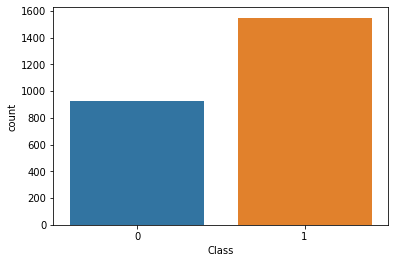

In [ ]:
sns.countplot(data['Class'])

#Defining independent and dependent variable

In [ ]:
x = data['Statement']
y = data['Class']
#print(x.shape)
#print(y.shape)

#Regular Expression

In [ ]:
def clean(text):
    text = re.sub('[%s]' % re.escape(punctuations), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\xa0', '', text)
    
    return text

cleaned_text = x.apply(lambda x: clean(str(x)))
cleaned_text

0       দেশে করোনাভাইরাসে আক্রান্ত হয়ে গত  ঘণ্টায়  জন ...
1       দ্বিতীয় বিশ্বযুদ্ধের পর থেকে বিশ্বের প্রভু হয়ে...
2       বাড়ির পাশেই ভিক্টোরিয়া পার্ক বিকেল হলেই সেখানে...
3       বাইরে বেরোচ্ছি না বেশ কিছুদিন ধরে বলা ভালো বের...
4       সবার মতো লেখকেরাও এখন ঘরবন্দী লেখকদের এই ঘরবন্...
                              ...                        
2528    এবার রাজধানীতে ঘটলো আরেকটি চাঞ্চল্যকর হত্যাকান...
2529    অবশেষে বেরিয়ে এলো শফিক রেহমানের থলের বেড়াল স...
2530    ছোটকাল থেকে আমি আপনার ভক্ত আমার জীবনে একটাই চা...
2535    এবার বাটে পেয়ে মুশফিকুর রহিমকে মেরে হাত পা ভে...
2540    এবার প্রকাশ্যে কলা খাওয়া নিষিদ্ধ হতে যাচ্ছে ম...
Name: Statement, Length: 2471, dtype: object

#Applying TF_IDF

In [ ]:
vector=TfidfVectorizer(use_idf=True,stop_words=stopwords, ngram_range=(1, 1))
vector.fit(x)
statement_tokenized = vector.fit_transform(x)
statement_tokenized.shape

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['অথব', 'অন', 'অবধ', 'অবশ', 'অর', 'আগ', 'আছ', 'আদ', 'আপন', 'আব', 'আম', 'আমর', 'ইত', 'ইহ', 'উই', 'উক', 'উচ', 'উত', 'উন', 'এক', 'একট', 'একব', 'এখ', 'এট', 'এতট', 'এদ', 'এমনক', 'ওক', 'ওখ', 'ওদ', 'ওয', 'ওয়', 'কট', 'কব', 'কমন', 'কয', 'কর', 'করছ', 'করত', 'করব', 'করল', 'কয়', 'খত', 'চল', 'জনক', 'তথ', 'তব', 'তর', 'থম', 'ধর', 'নঐ', 'নও', 'নজন', 'নত', 'নয', 'পক', 'পষ', 'ফল', 'বক', 'বদল', 'বয', 'বর', 'বল', 'বলত', 'বস', 'বহ', 'মত', 'মধ', 'মন', 'যওজ', 'যতট', 'যথ', 'যদ', 'যন', 'যবহ', 'যভ', 'যম', 'রও', 'রণ', 'রত', 'রথম', 'রপর', 'রভ', 'রয', 'রযন', 'লক', 'ষয', 'সঙ', 'সম', 'সমস', 'হইত', 'হইব', 'হইয', 'হওয', 'হচ', 'হব', 'হয'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(2471, 7895)

#Dataset Splitting

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(statement_tokenized, y, random_state=4,test_size=0.2)
x_val_train, x_val_test, y_val_train, y_val_test = train_test_split(x_train, y_train , random_state=4,test_size=0.12)
print(x_train.shape)  # 80% Train set
print(x_test.shape)   # 20% Test set
print(x_val_train.shape)  # 70% Train_val set
print(x_val_test.shape)     # 10% Test_val set

#print(type(x_val_train))

(1976, 7895)
(495, 7895)
(1738, 7895)
(238, 7895)


#MNB model testing 

**Validation Set**

In [ ]:
MNB = naive_bayes.MultinomialNB()

model1=MNB.fit(x_val_train, y_val_train)

m1 = model1.predict(x_val_test)

a1 = accuracy_score(y_val_test, m1)
print("Accuracy :", a1)

ms_f1 = f1_score(y_val_test, m1)
print("F1 :", ms_f1)

Accuracy : 0.9369747899159664
F1 : 0.9508196721311475


**Confusion Matrix**

Confusion matrix, without normalization


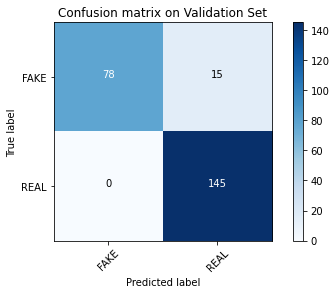

In [ ]:
from sklearn.metrics import confusion_matrix

cm = metrics.confusion_matrix(y_val_test, m1)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'],extention='on Validation Set')

**Test Set**

In [ ]:
m1 = model1.predict(x_test)

a1 = accuracy_score(y_test, m1)
print("Accuracy :", a1)

ms_f1 = f1_score(y_test, m1)
print("F1 :", ms_f1)

Accuracy : 0.9353535353535354
F1 : 0.9520958083832335


Confusion matrix, without normalization


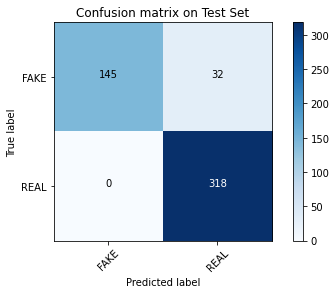

In [ ]:
cm = metrics.confusion_matrix(y_test, m1)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'],extention='on Test Set')

#SVM model testing 

**Finding best "C" and "gamma" value**

In [ ]:
C_list = [0.1, 1, 10, 100]
gamma_list = [0.001, 0.01, 0.1, 1]



best_acc = -np.inf

for C in C_list:
  for gamma in gamma_list:
    svm_test = SVC(C=C, gamma=gamma)
    svm_test.fit(x_val_train, y_val_train)
    predictions = svm_test.predict(x_val_test)
    acc = accuracy_score(y_val_test, predictions)
    if acc > best_acc:
      best_acc = acc
      best_C = C
      best_gamma = gamma

print(best_acc)
print(best_C)
print(best_gamma)

0.9789915966386554
10
0.1


**Training SVM**

In [ ]:
svm = SVC(C=best_C, kernel='linear', gamma=best_gamma)
svm.fit(x_train, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
m2 = svm.predict(x_test)

a2 = accuracy_score(y_test, m2)
print("Accuracy :", a2)

ms_f3 = f1_score(y_test, m2)
print("F1 :", ms_f3)

Accuracy : 0.9777777777777777
F1 : 0.9828926905132193


Confusion matrix, without normalization


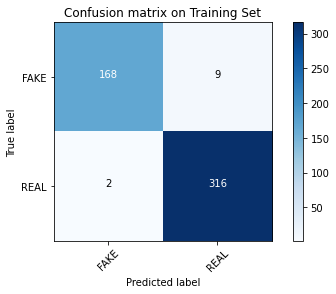

In [ ]:
cm = metrics.confusion_matrix(y_test, m2)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'],extention='on Training Set')

#**Test Set(IF needed-OPTIONAL)**

In [ ]:
m2 = svm.predict(x_test)

a1 = accuracy_score(y_test, m2)
print("Accuracy :", a1)

ms_f3 = f1_score(y_test, m2)
print("F1 :", ms_f3)

In [ ]:
cm = metrics.confusion_matrix(y_test, m2)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'],extention='on Test Set')